# PERBANDINGAN METODE KLASTER K-MEDOIDS DAN K-MEANS TERHADAP HASIL PERAMALAN KEMISKINAN DI INDONESIA MENGGUNAKAN BPNN
### by Riansyah Fazar Ramadhan

## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AutoReg

## Data Preprocessing

In [4]:
data = pd.read_excel('E:\GitHub\sherlock-final-project\pooled_data.xlsx', sheet_name="data")
data = data.iloc[:, 1:4]
data_ar = np.array(data)

## ACF-PACF

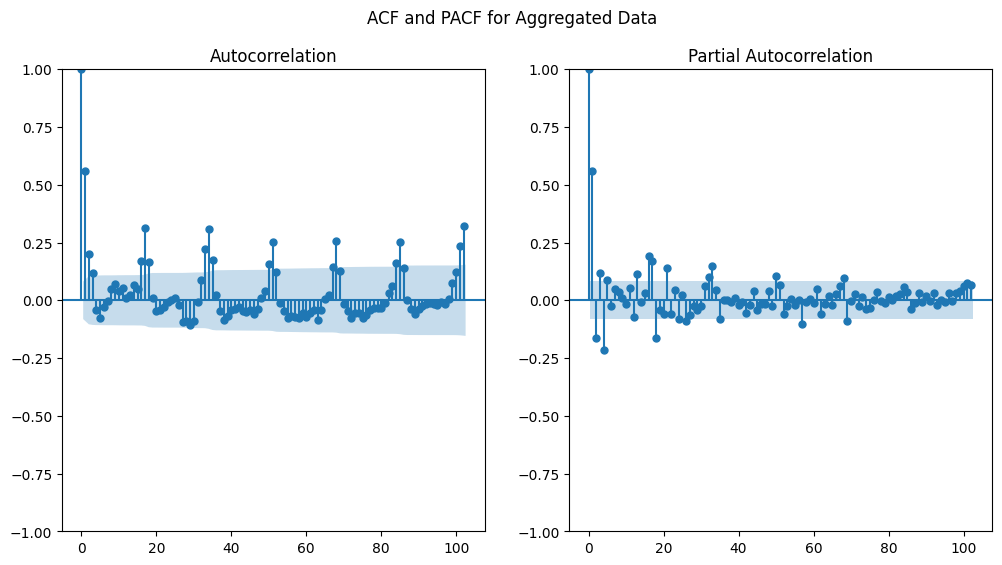

Suggested common N_PAST: 4


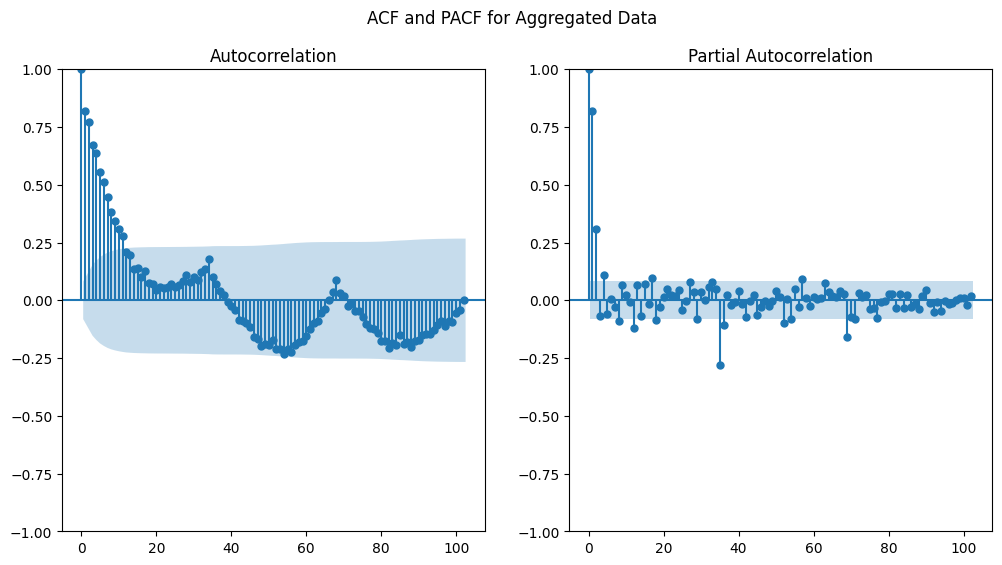

Suggested common N_PAST: 35


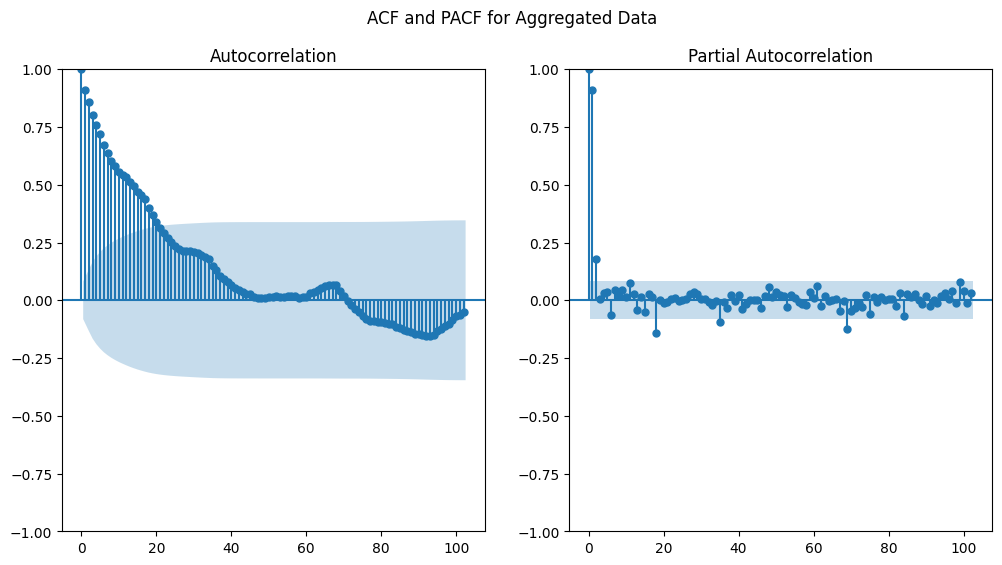

Suggested common N_PAST: 1


In [5]:
# Plot ACF and PACF for the aggregated data
def plot_acf_pacf(series, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)
    plt.subplot(121)
    plot_acf(series, ax=plt.gca(), lags=102)
    plt.subplot(122)
    plot_pacf(series, ax=plt.gca(), lags=102)
    plt.show()

# Function to determine significant lags based on PACF
def significant_pacf_lags(series, threshold=0.2):
    pacf_values = pacf(series, nlags=102)
    significant_lags = np.where(np.abs(pacf_values) > threshold)[0]
    return significant_lags[significant_lags != 0]

def x_lag(aggregated_series):
    plot_acf_pacf(aggregated_series, "ACF and PACF for Aggregated Data")
    # Calculate significant lags for the aggregated data
    significant_lags = significant_pacf_lags(aggregated_series)
    # Determine a common N_PAST
    common_n_past = max(significant_lags) if len(significant_lags) > 0 else 1

    print("Suggested common N_PAST:", common_n_past)

x_lag(data['x1'])
x_lag(data['x2'])
x_lag(data['x3'])

## 5. Terasvirta Linearity Test
#### Done in R language, check at terasvirtatest.R

## 6. Standarization

In [6]:
from sklearn.preprocessing import MinMaxScaler

def standardize_data(data):
    scaler = MinMaxScaler(feature_range=(-1,1))
    data_norm = scaler.fit_transform(data)
    return data_norm

data_norm = standardize_data(data)

## 7. Data Splitting

In [7]:
def windowed_dataset(series, batch_size, n_past, n_future, shift):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
BATCH_SIZE = 1
N_FUTURE = 1
SHIFT = 1
SPLIT_TIME = 442

In [10]:
x1_train = data_norm[:SPLIT_TIME,0]
x1_test = data_norm[SPLIT_TIME:,0]
x2_train = data_norm[:SPLIT_TIME,1]
x2_test = data_norm[SPLIT_TIME:,1]
x3_train = data_norm[:SPLIT_TIME,2]
x3_test = data_norm[SPLIT_TIME:,2]

train_set1 = windowed_dataset(series=x1_train, batch_size=BATCH_SIZE,
                            n_past=4, n_future=N_FUTURE,
                            shift=SHIFT)
test_set1 = windowed_dataset(series=x1_test, batch_size=BATCH_SIZE,
                            n_past=4, n_future=N_FUTURE,
                            shift=SHIFT)

train_set2 = windowed_dataset(series=x2_train, batch_size=BATCH_SIZE,
                            n_past=35, n_future=N_FUTURE,
                            shift=SHIFT)
test_set2 = windowed_dataset(series=x2_test, batch_size=BATCH_SIZE,
                            n_past=35, n_future=N_FUTURE,
                            shift=SHIFT)

train_set3 = windowed_dataset(series=x3_train, batch_size=BATCH_SIZE,
                            n_past=1, n_future=N_FUTURE,
                            shift=SHIFT)
test_set3 = windowed_dataset(series=x3_test, batch_size=BATCH_SIZE,
                            n_past=1, n_future=N_FUTURE,
                            shift=SHIFT)

## 8. Neural Network Architecture

In [ ]:
def mape(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    y_true = tf.maximum(y_true, epsilon)
    
    # Calculate MAPE
    mape = tf.reduce_mean(tf.abs((y_true - y_pred) / y_true))
    return mape

In [19]:
def modelling(train_dataset, test_dataset, epoch, loss_function, metrics, optimizer, activation, hidden_node):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(4,)),
                tf.keras.layers.Dense(hidden_node, activation=activation),
                tf.keras.layers.Dense(1)
                ])
        model.compile(loss=loss_function, optimizer=optimizer, metrics=[metrics])
        history = model.fit(train_dataset, epochs=epoch, validation_data=test_dataset)
        if __name__ == '__main__':
                model.save(f"model_{hidden_node}.h5")
        final_loss = history.history['loss'][-1]
        weights = model.get_weights()
        return final_loss, weights[0], weights[1], weights[2], weights[3]

In [ ]:
model_sum = pd.DataFrame(columns=['mse', 'hl_weights', 'hl_bias', 'ol_weights', 'ol_bias'])
for n in range(1, 21):
    a,b,c,d,e = modelling(train_dataset=train_set1, 
                            test_dataset=test_set1,
                            epoch=100, 
                            loss_function='mse',
                            metrics = 'mae', 
                            optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                            activation='sigmoid',
                            hidden_node=n)
    model_sum.loc[n] = [a,b,c,d,e]                

In [21]:
model_sum.to_excel('model_train_sumary.xlsx')